# Classification with Keras (Titanic dataset)
#### 참고 : tensorflow.keras 공식 문서 (Official API Docs) @ https://www.tensorflow.org/api_docs/python/tf/keras

## Data loading & preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
titanic_df = pd.read_csv('../titanic.csv')
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [17]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_df.isna().sum()/len(titanic_df)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [19]:
titanic_df.Ticket[:3]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
Name: Ticket, dtype: object

In [12]:
# 티켓의 고유값이 76%로 패턴 파악 어려움!
titanic_df.Ticket.nunique()/len(titanic_df)

0.7643097643097643

## drop column
cabin - 너무 많은 결측치가 존재(70%이상) <br>
PassengerId - PassengerId는 일련번호로 의미 파악 어려워 drop<br>
Ticket - ticket 번호에서 패턴파악 어려움<br>
Name - 호칭만 남김<br>

In [20]:
del titanic_df['Cabin'] 
del titanic_df['PassengerId'] 
del titanic_df['Ticket'] 

titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name']

In [24]:
titanic_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')

In [25]:
rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


## Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [28]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [29]:
from sklearn import model_selection

In [30]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data, titanic_target,
                                                                                 test_size= 0.3,
                                                                                 random_state=42)
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((623, 8), (268, 8), (623, 1), (268, 1))

## Change normal labels to one-hot labels

In [33]:
train_label[:5]

,Survived
445,1
650,0
172,1
450,0
314,0


In [34]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

train_label.shape, test_label.shape
# from sklearn import preprocessing
# enc = preprocessing.OneHotEncoder(categories='auto') # Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

((623, 2), (268, 2))

In [35]:
train_label[:2]

array([[0., 1.],
       [1., 0.]], dtype=float32)

## Bulid & Train the model

In [36]:
import tensorflow as tf

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [38]:
model = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers), 바탕

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [39]:
# "Compile" the model description (Configures the model for training)

model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy,  # spase_categorical_crossentropy
              metrics=[metrics.categorical_accuracy]) # Precision / Recall / F1-Score 적용하기 @ https://j.mp/3cf3lbi

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               1

In [42]:
# "Fit" the model on training data

history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3)

Epoch 1/20
5/5 [==============================] - 0s 20ms/step - loss: 2.4068 - categorical_accuracy: 0.6078 - val_loss: 0.9946 - val_categorical_accuracy: 0.7112
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 1.1043 - categorical_accuracy: 0.7156 - val_loss: 0.6268 - val_categorical_accuracy: 0.7968
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - loss: 0.8799 - categorical_accuracy: 0.7339 - val_loss: 0.4431 - val_categorical_accuracy: 0.8289
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.6451 - categorical_accuracy: 0.7844 - val_loss: 0.4448 - val_categorical_accuracy: 0.8182
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.7384 - categorical_accuracy: 0.7477 - val_loss: 0.6231 - val_categorical_accuracy: 0.7754
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.7542 - categorical_accuracy: 0.7592 - val_loss: 0.5284 - val_categorical_accuracy: 0.8128
Epoch 7/20
5/5 [===========

## Evaluate
### "Evaluate" the model on test data


In [43]:
result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 1ms/step - loss: 0.4655 - categorical_accuracy: 0.8172
loss (cross-entropy) : 0.46554526686668396
test accuracy : 0.8171641826629639


In [44]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [45]:
print(history.history['categorical_accuracy']) # y좌표

[0.607798159122467, 0.7155963182449341, 0.7339449524879456, 0.7844036817550659, 0.747706413269043, 0.7591742873191833, 0.7683486342430115, 0.7316513657569885, 0.7844036817550659, 0.747706413269043, 0.7591742873191833, 0.786697268486023, 0.8211008906364441, 0.8371559381484985, 0.752293586730957, 0.8004587292671204, 0.8050458431243896, 0.7752293348312378, 0.7798165082931519, 0.8119266033172607]


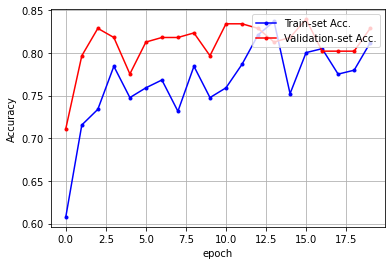

In [46]:
acc = history.history['categorical_accuracy'] # 20
val_acc = history.history['val_categorical_accuracy'] # 20

x_len = np.arange(len(acc)) # acc= = 20

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### Predict on test data

In [47]:
model.predict(test_data)

array([[7.88420066e-02, 9.21157956e-01],
       [9.28635120e-01, 7.13649094e-02],
       [9.21054006e-01, 7.89460093e-02],
       [3.26448604e-02, 9.67355192e-01],
       [5.24565019e-02, 9.47543442e-01],
       [4.09253349e-04, 9.99590814e-01],
       [3.58440191e-01, 6.41559780e-01],
       [8.33994865e-01, 1.66005135e-01],
       [9.23033431e-02, 9.07696605e-01],
       [1.60449184e-03, 9.98395503e-01],
       [8.91757905e-01, 1.08242132e-01],
       [9.63298082e-01, 3.67019400e-02],
       [8.93698096e-01, 1.06301829e-01],
       [9.02608216e-01, 9.73917842e-02],
       [9.52375054e-01, 4.76249717e-02],
       [7.28340878e-04, 9.99271691e-01],
       [8.91757905e-01, 1.08242132e-01],
       [3.58440191e-01, 6.41559780e-01],
       [9.85505283e-01, 1.44947218e-02],
       [9.20912445e-01, 7.90875703e-02],
       [9.21054006e-01, 7.89460093e-02],
       [9.20912445e-01, 7.90875703e-02],
       [6.49688423e-01, 3.50311607e-01],
       [9.21054006e-01, 7.89460093e-02],
       [9.210540

In [49]:
np.argmax(model.predict(test_data),axis = 1)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

In [52]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]]) 

print(sample_data.shape)
print(model.predict(sample_data))
print(np.argmax(model.predict(sample_data),axis = 1))

(1, 8)
[[0.9298308  0.07016917]]
[0]


In [69]:
del train_data
del train_label
del test_data
del test_label
del model
del history
del result

# Regression with Keras (Boston house price dataset)

#### 참고 : tensorflow.keras 공식 문서 (Official API Docs) @ https://www.tensorflow.org/api_docs/python/tf/keras

## Data loading & preprocessing

In [54]:
from sklearn import datasets, preprocessing # Scikit-learn (sklearn)
import warnings
warnings.filterwarnings('ignore')

In [55]:
datasets.load_boston().keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [57]:
# print(datasets.load_boston()['DESCR'])

In [58]:
boston_df = pd.DataFrame(datasets.load_boston().data)
boston_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [60]:
X = datasets.load_boston().data
y = datasets.load_boston().target

X.shape, y.shape

((506, 13), (506,))

## Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [64]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(X, y,
                                                                                 test_size=0.3,
                                                                                 random_state=42)
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((354, 13), (152, 13), (354,), (152,))

In [66]:
# Apply standard scaling on x_data (Standardization)
sc = preprocessing.StandardScaler()

sc.fit_transform(train_data)
train_data = sc.transform(train_data)
test_data = sc.transform(test_data)

train_data.shape, test_data.shape

((354, 13), (152, 13))

## Bulid & Train the model

In [81]:
model = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=13, units=64, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))
model.add(layers.Dropout(rate=0.4)) # Dropout-layer

model.add(layers.Dense(units=1, activation=None)) 

In [82]:
model.compile(optimizer=optimizers.Adam(),
             loss = losses.mean_squared_error, # MSE
             metrics=[metrics.mean_squared_error])

In [83]:
# verbose = 0 : 실행단계를 보여주지 않음
history = model.fit(train_data, train_label,
                   batch_size=100, epochs=1000,
                   validation_split=0.3, verbose = 0)

In [84]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

## Evaluate

In [85]:
result = model.evaluate(test_data, test_label)

print('loss (mean_squared_error):', result[0])

5/5 [==============================] - 0s 636us/step - loss: 10.7764 - mean_squared_error: 10.7764
loss (mean_squared_error): 10.776436805725098


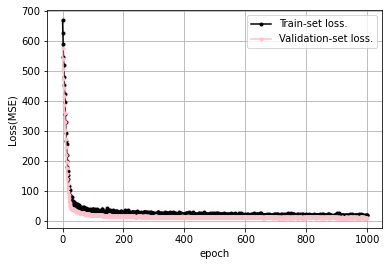

In [86]:
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker = '.', c='black', label='Train-set loss.')
plt.plot(x_len, val_loss, marker ='.', c='pink', label = 'Validation-set loss.')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()

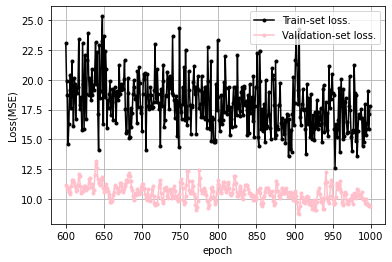

In [90]:
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']

x_len = np.arange(len(loss))

# epoch 200 ~ epoch 1000
plt.plot(x_len[600:], loss[600:], marker='.', c='black', label="Train-set loss.")
plt.plot(x_len[600:], val_loss[600:], marker='.', c='pink', label="Validation-set loss.")

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()

In [92]:
test_data.shape

(152, 13)

## Predict

In [93]:
model.predict(test_data)

array([[26.21493  ],
       [32.762695 ],
       [14.874659 ],
       [22.618387 ],
       [15.721954 ],
       [20.008669 ],
       [19.442842 ],
       [13.939386 ],
       [22.293558 ],
       [19.54935  ],
       [20.434725 ],
       [20.462593 ],
       [ 5.812163 ],
       [19.89794  ],
       [17.90909  ],
       [21.534395 ],
       [19.575617 ],
       [11.019358 ],
       [47.227924 ],
       [12.022556 ],
       [22.653193 ],
       [24.94913  ],
       [15.356491 ],
       [23.125387 ],
       [18.124166 ],
       [15.646181 ],
       [19.906721 ],
       [11.88488  ],
       [17.924265 ],
       [18.619139 ],
       [23.563322 ],
       [23.23477  ],
       [17.827944 ],
       [26.857868 ],
       [14.309525 ],
       [15.954964 ],
       [32.198067 ],
       [19.894762 ],
       [19.909666 ],
       [23.534803 ],
       [19.593697 ],
       [30.197622 ],
       [51.94737  ],
       [18.453188 ],
       [24.672253 ],
       [13.838093 ],
       [15.524668 ],
       [24.91

In [94]:
np.argmax(model.predict(test_data), axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
# new user data update sample
sample_data = np.array([[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, 4.9671, 2.0, 242.0, 17.8, 396.90, 9.14]])

In [97]:
sample_data = sc.transform(sample_data)

print(sample_data.shape)
print(model.predict(sample_data))
print(np.argmax(model.predict(sample_data),axis = 1))

(1, 13)
[[559.08093]]
[0]
